In [20]:
import numpy as np
import torch
import torch.backends.cudnn as cudnn
from timm.models import create_model
import models_dyvim
import utils
import os
import matplotlib.pyplot as plt

In [21]:
model_type = 'VimTinyDiffPruning'
model_path = '/root/autodl-tmp/DynamicVim/vim/output/dyvim/best_checkpoint.pth'
num_classes = 100
model = create_model(
    model_type,
    pretrained=False,
    num_classes=num_classes,
    drop_rate=0,
    drop_path_rate=0,
    drop_block_rate=None,
    img_size=224,
    token_ratio=[0.7, 0.7 ** 2, 0.7 ** 3],
    pruning_loc=[6, 12, 18],
)
checkpoint = torch.load(model_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
model.to('cuda')
model.eval()

VisionMambaDiffPruning(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0, inplace=False)
  (head): Linear(in_features=192, out_features=100, bias=True)
  (drop_path): Identity()
  (layers): ModuleList(
    (0-23): 24 x Block(
      (mixer): Mamba(
        (in_proj): Linear(in_features=192, out_features=768, bias=False)
        (conv1d): Conv1d(384, 384, kernel_size=(4,), stride=(1,), padding=(3,), groups=384)
        (act): SiLU()
        (x_proj): Linear(in_features=384, out_features=44, bias=False)
        (dt_proj): Linear(in_features=12, out_features=384, bias=True)
        (conv1d_b): Conv1d(384, 384, kernel_size=(4,), stride=(1,), padding=(3,), groups=384)
        (x_proj_b): Linear(in_features=384, out_features=44, bias=False)
        (dt_proj_b): Linear(in_features=12, out_features=384, bias=True)
        (out_proj): Linear(in_features=384, out_features=192, bias=False)
      )
  

In [22]:
from PIL import Image
import torchvision.transforms as transforms

IMAGENET_DEFAULT_MEAN = [0.485, 0.456, 0.406]
IMAGENET_DEFAULT_STD = [0.229, 0.224, 0.225]
patch_size = 16
num_patches_per_row = 224 // patch_size

def transform_for_eval(image_path, input_size=224):
    transform_eval = transforms.Compose([
        transforms.Resize(int(input_size)),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
    ])
    img = Image.open(image_path).convert('RGB')
    transformed_img = transform_eval(img)
    img_for_model = transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)(transformed_img)
    img_for_display = transforms.ToPILImage()(transformed_img)
    return img_for_model.unsqueeze(0).to('cuda'), img_for_display

def place_visible_patches(img_for_display_np, visible_patches):
    output_image = np.ones((224, 224, 3)) * 255
    for idx in visible_patches:
        row = idx // num_patches_per_row
        col = idx % num_patches_per_row
        
        # Calculate the patch coordinates
        start_row = row * patch_size
        start_col = col * patch_size
        
        # Place the patch in the output image
        output_image[start_row:start_row + patch_size, start_col:start_col + patch_size] = img_for_display_np[start_row:start_row + patch_size, start_col:start_col + patch_size]

    return output_image

Processing image 1
Raw image


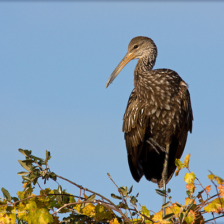

Pruned 1 time(s)


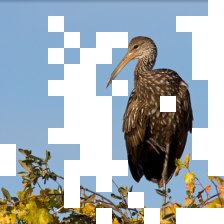

Pruned 2 time(s)


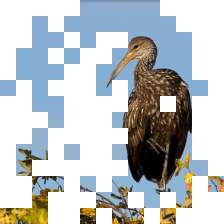

Pruned 3 time(s)


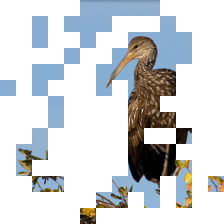

Processing image 2
Raw image


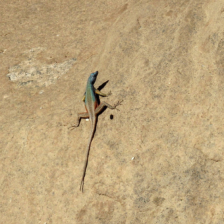

Pruned 1 time(s)


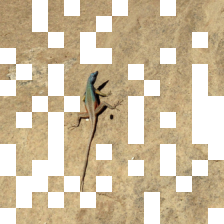

Pruned 2 time(s)


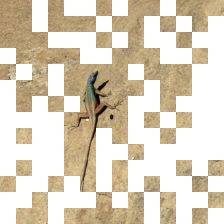

Pruned 3 time(s)


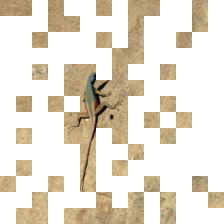

Processing image 3
Raw image


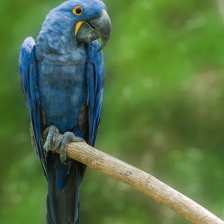

Pruned 1 time(s)


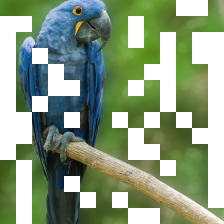

Pruned 2 time(s)


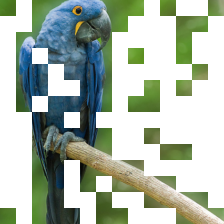

Pruned 3 time(s)


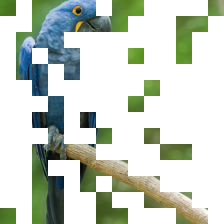

In [28]:
image_paths = ['/root/autodl-tmp/ImageNet_100/val/n02013706/ILSVRC2012_val_00003053.JPEG', '/root/autodl-tmp/ImageNet_100/val/n01687978/ILSVRC2012_val_00040115.JPEG', '/root/autodl-tmp/ImageNet_100/val/n01818515/ILSVRC2012_val_00047547.JPEG']

for i, image_path in enumerate(image_paths):
    print(f'Processing image {i + 1}')
    img_for_model, img_for_display = transform_for_eval(image_path)
    print('Raw image')
    img_for_display.show()
    with torch.no_grad():
        output, pred_decisions = model(img_for_model)
    img_for_display_np = np.array(img_for_display)
    for j, visible_patches in enumerate(pred_decisions):
        visible_patches = visible_patches[0].tolist()
        output_image = place_visible_patches(img_for_display_np, visible_patches)
        output_image = Image.fromarray((output_image).astype(np.uint8))
        print(f'Pruned {j + 1} time(s)')
        output_image.show()
